<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/Text_Classification_with_Bi_directional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task is to create a text classification model using LSTM NN to predict whether or not an email is spam.

### Load and Observe Data: 

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Check system readiness
! nvidia-smi

Wed Aug 19 20:47:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check file counts in the directory

In [ ]:
cd /content/drive/My Drive/Data/ClassificationData/spam

In [ ]:
ls -1 |grep spam.txt | wc -l

4499


In [ ]:
cd /content/drive/My Drive/Data/ClassificationData/ham

In [ ]:
ls -1 |grep ham.txt | wc -l

1500


Load and combine text and label

In [ ]:
import glob
import os
from random import shuffle
def pre_process_data(filepath):
  positive_path = os.path.join(filepath, 'spam')
  negative_path = os.path.join(filepath, 'ham')
  pos_label = 1
  neg_label = 0
  dataset = []

  for filename in glob.glob(os.path.join(positive_path, '*.txt')):
    with open(filename, 'r', encoding='utf-8',
                 errors='ignore') as f:
      dataset.append((pos_label, f.read()))

  for filename in glob.glob(os.path.join(negative_path, '*.txt')):
    with open(filename, 'r', encoding='utf-8',
                 errors='ignore') as f:
      dataset.append((neg_label, f.read()))

  shuffle(dataset)

  return dataset

dataset = pre_process_data("/content/drive/My Drive/Data/ClassificationData")

In [ ]:
# Visually check data
dataset[:5]

[(1,
  "Subject: eshopping at our chemist - site helps you sav a lot on rneds .\nflnd a better way to sav on medicals . at our chemist - site , you have the\nbestselections on quality rneds .\nchoose our store for a range of quality medicaments on pain , swelling ,\nereection dysfunction , highcholesterol , obesity , stress , musclerelaxant and\nman ' s care .\nour company cooperates with the most experienced logistic companies\nto ensure timely shipment . , check this superssale on quality rneds at our\ncyber store .\nbrowse the affordable ones\nat cyber chemist .\nat our store , customers can gget their case profile reviewed for ffree .\nshopping for rneds is much easier . at your chemist - site , i can select from\nthese top - selling rneds . and best of all , they are much , much ccheaper than\nthose sold at the local pharrnacy . and also thank you for providing timely\nservices . - - tina d . in la\nhave mentioned . . . . we closely akin t\nrest ; but what they called ' o reality 

In [ ]:
# save the combined file
import pickle

with open('/content/drive/My Drive/dataset.data', 'wb') as file:
  pickle.dump(dataset, file)

In [ ]:
# load the saved combined file
import pickle

with open('/content/drive/My Drive/dataset.data', 'rb') as file:
    # read the data as binary data stream
    dataset = pickle.load(file)

### Data Processing:

Prepare X (input) and Y (output)

In [ ]:
X=[text[1] for text in dataset]
Y=[text[0] for text in dataset]

In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer

def Token(text_list):
  X_Cleaned=[]
  for text in X:
    pattern = r'(Subject: )'   # Remove the string shown at beginning of every document
    processed_text=re.sub(pattern, '', text)
    X_Cleaned.append(processed_text)
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(X_Cleaned)
  X_Tokenized=tokenizer.texts_to_sequences(X_Cleaned)

  
  return X_Tokenized, tokenizer.word_counts, tokenizer.word_index, tokenizer.document_count


Token_Profile=Token(X)

X_Tokenized=Token_Profile[0]


In [ ]:
# Split data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_Tokenized,Y, test_size = 0.15, random_state=80)

y_test_array=np.asarray(Y_test) # compared againt the test prediction

The ham and spam classes are highly imbalanced (1:3), the next step is to balance the two classes to about the same length. Below is a simple up-sampleing approch by simply replicating exsiting ham texts. 

In [ ]:
import numpy as np

# Select ham cases
idxh = np.argwhere(np.array(Y_train)==0)
x_train0 = np.array(X_train)[idxh]
y_train0 = np.array(Y_train)[idxh]

# Select spam cases
idxs = np.argwhere(np.array(Y_train)==1)
x_train_Spam = np.array(X_train)[idxs]
y_train_Spam = np.array(Y_train)[idxs]

Oversample the Ham text to match the length of Spam text

In [ ]:
# Replicate number of times (approximately match the length)

times= len(y_train_Spam)//len(y_train0)

x_train_Ham = np.tile(x_train0, (times,1))
y_train_Ham = np.tile(y_train0, (times,1))

print('Ham: {}'.format(len(x_train_Ham)), 'Spam: {}'.format(len(x_train_Spam)), 'Ratio: {:.2f}:1'.format(len(x_train_Ham)/len(x_train_Spam)))

Ham: 3786 Spam: 3837 Ratio: 0.99:1


Assmble Ham text and Spam text

In [ ]:
x_train_assembled = np.concatenate((x_train_Ham, x_train_Spam), axis = None)
y_train_assembled = np.concatenate((y_train_Ham, y_train_Spam), axis = None)

print(len(x_train_assembled), len(y_train_assembled))

7623 7623


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[Text(0, 0.5, 'frequency of occurence'), Text(0.5, 0, 'total word count')]

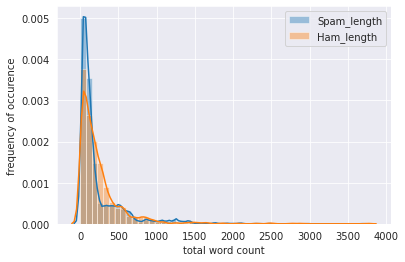

In [ ]:
# observe word count distribution
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

# Find the length of each element 
Spam_length = [len(i[0]) for i in x_train_Spam] 
Ham_length = [len(i[0]) for i in x_train_Ham] 

fig, ax = plt.subplots()
sns.distplot(Spam_length, label='Spam_length')
sns.distplot(Ham_length, label='Ham_length')
ax.legend()
ax.set(xlabel='total word count', ylabel='frequency of occurence')

Graph shows majority of text has length less than 300 words for both Spam and Ham classes. Each text is therefore padded to 256 word length before feeding into the model.

In [ ]:
import tensorflow as tf

max_sentence_length=256

train_data = tf.keras.preprocessing.sequence.pad_sequences(x_train_assembled,
                                                        padding='post',
                                                       maxlen=max_sentence_length)
test_data = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='post',
                                                       maxlen=max_sentence_length)

### Building the Model:

Set up Bi-directional GRU model

In [ ]:
vocab_size = len(Token_Profile[2])+10000 #an estimate of the true vocabulary size

Sequence_length=256
Embedding_size=64
Number_neuron=128
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=Embedding_size, input_length=Sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(Number_neuron, dropout=0.4,
        recurrent_dropout=0.3)),
    tf.keras.layers.Dense(Number_neuron, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 64)           5188480   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               148992    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 5,370,497
Trainable params: 5,370,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Shuffle training data for cross validation during training cycle
Frac = 0.75 # fraction of training data used for training. Remaining is for validation.
idx = np.arange(len(train_data))
np.random.shuffle(idx) # shuffle then get the top 75%, equivilent to random draw

idxs = idx[:round(len(idx)*Frac)] # Select random 75% for training data
partial_x_train = train_data[idxs]
partial_y_train = y_train_assembled[idxs]

x_val = np.delete(train_data, idxs.tolist(), axis=0) # select remaining as validation data
y_val = np.delete(y_train_assembled, idxs.tolist(), axis=0)

In [ ]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping

model_fit= model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
                    verbose=1)

Epoch 1/40
12/12 [==============================] - 68s 6s/step - loss: 0.6823 - acc: 0.5938 - val_loss: 0.6427 - val_acc: 0.7177
Epoch 2/40
12/12 [==============================] - 67s 6s/step - loss: 0.4959 - acc: 0.8443 - val_loss: 0.2578 - val_acc: 0.9292
Epoch 3/40
12/12 [==============================] - 67s 6s/step - loss: 0.1192 - acc: 0.9636 - val_loss: 0.0869 - val_acc: 0.9664
Epoch 4/40
12/12 [==============================] - 67s 6s/step - loss: 0.0301 - acc: 0.9900 - val_loss: 0.0486 - val_acc: 0.9822
Epoch 5/40
12/12 [==============================] - 67s 6s/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.0276 - val_acc: 0.9911
Epoch 6/40
12/12 [==============================] - 67s 6s/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0317 - val_acc: 0.9885
Epoch 7/40
12/12 [==============================] - 67s 6s/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0348 - val_acc: 0.9874


### Model Performance Evaluation:

In [ ]:
# Evaluation metrics (loss & acc) on test data
results = model.evaluate(test_data, y_test_array)

29/29 [==============================] - 3s 106ms/step - loss: 0.0489 - acc: 0.9833


Model performance over epoches

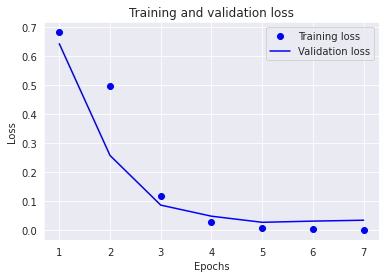

In [ ]:
import matplotlib.pyplot as plt

acc = model_fit.history['acc']
val_acc = model_fit.history['val_acc']
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

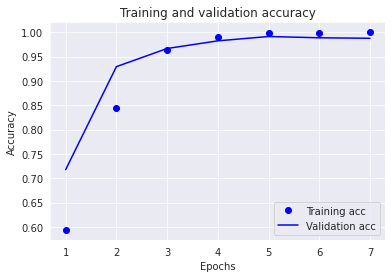

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Both loss and accuracy over epoches graphs showing the model performs well with no overfitting on training set.

Model performance- Precision & Recall

In [ ]:
predicted = model.predict(test_data)

predicted[predicted > 0.5] = 1
predicted[predicted <= 0.5] = 0
predictedf = predicted.flatten().astype(int)

import pandas as pd
df3 = pd.DataFrame(data=predictedf, columns=['predicted'])
refdf = pd.DataFrame(data=y_test_array, columns=['actual'])

y_actu = pd.Series(refdf['actual'], name='ACTUAL')
y_pred = pd.Series(df3['predicted'], name='PREDICTED')
predicted_results = y_pred.tolist()
truth = y_actu.tolist()

Confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Confusion

Predicted,0,1,All
Actual,,,
0,231,7,238
1,8,654,662
All,239,661,900


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(truth, predicted_results)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       238
           1       0.99      0.99      0.99       662

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



Model produces high precision and recall for both Spam and Ham classification.